# Download data

In [1]:
!pip install imdb-sqlite

In [2]:
!imdb-sqlite

2021-05-13 06:34:22,391 GET https://datasets.imdbws.com/name.basics.tsv.gz -> downloads/name.basics.tsv.gz
2021-05-13 06:34:25,233 GET https://datasets.imdbws.com/title.basics.tsv.gz -> downloads/title.basics.tsv.gz
2021-05-13 06:34:26,933 GET https://datasets.imdbws.com/title.akas.tsv.gz -> downloads/title.akas.tsv.gz
2021-05-13 06:34:32,007 GET https://datasets.imdbws.com/title.principals.tsv.gz -> downloads/title.principals.tsv.gz
2021-05-13 06:34:39,510 GET https://datasets.imdbws.com/title.episode.tsv.gz -> downloads/title.episode.tsv.gz
2021-05-13 06:34:40,033 GET https://datasets.imdbws.com/title.ratings.tsv.gz -> downloads/title.ratings.tsv.gz
2021-05-13 06:34:40,126 Populating database: imdb.db
2021-05-13 06:34:40,127 Applying schema
2021-05-13 06:34:40,128 Importing file: downloads/name.basics.tsv.gz
2021-05-13 06:34:40,128 Reading number of rows ...
2021-05-13 06:34:45,647 Inserting rows into table: people
100% 10921808/10921808 [02:02<00:00, 89266.87 rows/s]
2021-05-13 06:3

In [4]:
import sqlite3 
con = sqlite3.connect("imdb.db")

In [5]:
import pandas as pd

To explore the structure of the database we look up the names of all the tables

In [20]:
import sqlite3
con = sqlite3.connect('imdb.db')

def sql_fetch(con):
    cursorObj = con.cursor()
    cursorObj.execute('SELECT name from sqlite_master where type= "table"')
    print(cursorObj.fetchall())

sql_fetch(con)

[('people',), ('titles',), ('akas',), ('crew',), ('episodes',), ('ratings',)]


In [21]:
cur = con.cursor()
sql = """ 
SELECT * FROM titles
"""
# cur.execute(sql, con)
rows = cur.fetchall()
df = pd.read_sql(sql, con)
df.head(5)

,title_id,type,primary_title,original_title,is_adult,premiered,ended,runtime_minutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,NaN,1.0,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,NaN,5.0,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,NaN,4.0,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,NaN,12.0,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,NaN,1.0,"Comedy,Short"


Looking at the columns in the ratings table:

In [22]:
cursor = con.execute('select * from ratings')
names = list(map(lambda x: x[0], cursor.description))

names

['title_id', 'rating', 'votes']

Looking at the columns of the titles table:

In [23]:
cursor = con.execute('select * from titles')
names = list(map(lambda x: x[0], cursor.description))

names

['title_id',
 'type',
 'primary_title',
 'original_title',
 'is_adult',
 'premiered',
 'ended',
 'runtime_minutes',
 'genres']

Joining ratings and titles to get one dataframe

In [24]:
query = """
SELECT * FROM titles
JOIN ratings
ON titles.title_id = ratings.title_id
"""
cur = con.cursor()

df = pd.read_sql(query, con)
df.head(5)

,title_id,type,primary_title,original_title,is_adult,premiered,ended,runtime_minutes,genres,title_id,rating,votes
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,NaN,1.0,"Documentary,Short",tt0000001,5.7,1702
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,NaN,5.0,"Animation,Short",tt0000002,6.1,210
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,NaN,4.0,"Animation,Comedy,Romance",tt0000003,6.5,1458
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,NaN,12.0,"Animation,Short",tt0000004,6.1,123
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,NaN,1.0,"Comedy,Short",tt0000005,6.1,2259


# Clean and prepare data

Select only movies with at least 5000 votes

In [28]:
pd.options.mode.chained_assignment = None  # default='warn'

In [165]:
small_df = df[df['votes'] > 5000]
small_df.shape

(18166, 12)

In [108]:
small_df.head(5)

,title_id,type,primary_title,original_title,is_adult,premiered,ended,runtime_minutes,genres,title_id,rating,votes
9,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895.0,NaN,1.0,"Documentary,Short",tt0000010,6.9,6321
11,tt0000012,short,The Arrival of a Train,L'arrivée d'un train à La Ciotat,0,1896.0,NaN,1.0,"Documentary,Short",tt0000012,7.4,10864
300,tt0000417,short,A Trip to the Moon,Le voyage dans la lune,0,1902.0,NaN,13.0,"Adventure,Comedy,Fantasy",tt0000417,8.2,45060
310,tt0000439,short,The Great Train Robbery,The Great Train Robbery,0,1903.0,NaN,11.0,"Action,Crime,Short",tt0000439,7.3,17676
1585,tt0004972,movie,The Birth of a Nation,The Birth of a Nation,0,1915.0,NaN,195.0,"Drama,History,War",tt0004972,6.2,23110


In [31]:
from tqdm import tqdm

Split genres

In [107]:
new_df = pd.DataFrame()
counter = 0

for i in tqdm(small_df['genres']):
    genres = i.split(',')
    if len(genres) > 1:
        for j in genres:
            a = pd.DataFrame({'title': small_df.iloc[counter]['primary_title'], 
                                'genre': j, 
                                'year': small_df.iloc[counter]['premiered'],
                                'rating': small_df.iloc[counter]['rating']}, index=[counter])
            new_df = new_df.append(a, ignore_index=True)
    counter += 1


100%|██████████| 18166/18166 [02:43<00:00, 111.18it/s]


Dropping empty instances:

In [109]:
new_df = new_df.dropna()

Visualizing data by grouping it by genre: building scatterplots for pairs of genres that reflect ratings of movies throughout the years

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

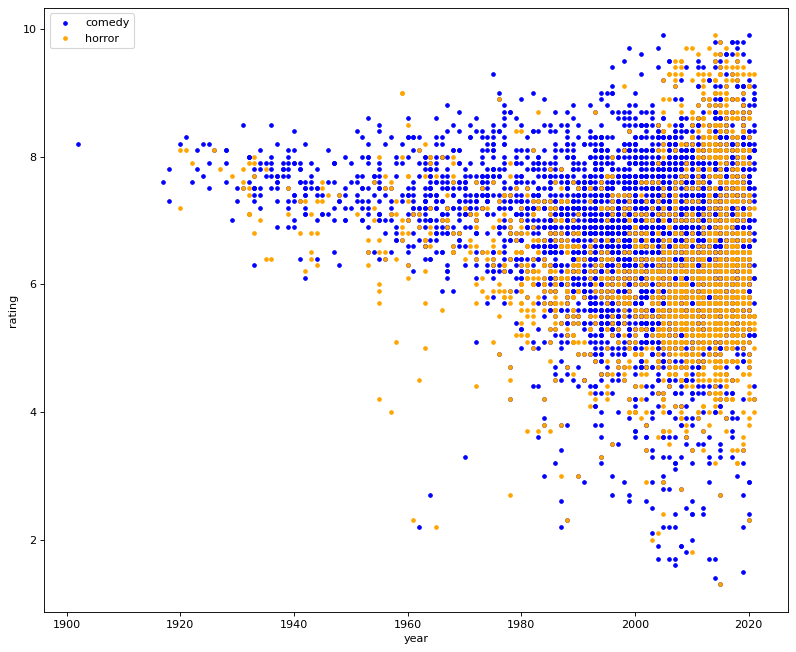

In [121]:
year_comedy = new_df[new_df['genre'] == 'Comedy']['year']
rating_comedy = new_df[new_df['genre'] == 'Comedy']['rating']

year_horror = new_df[new_df['genre'] == 'Horror']['year']
rating_horror = new_df[new_df['genre'] == 'Horror']['rating']

plt.figure(figsize=(12,10), dpi= 80)

plt.scatter(year_comedy, rating_comedy, color='blue', label='comedy', s=10)
plt.scatter(year_horror, rating_horror, color='orange', label='horror', s=10)

plt.ylabel('rating')
plt.xlabel('year')
plt.legend(loc='best') 
plt.show()

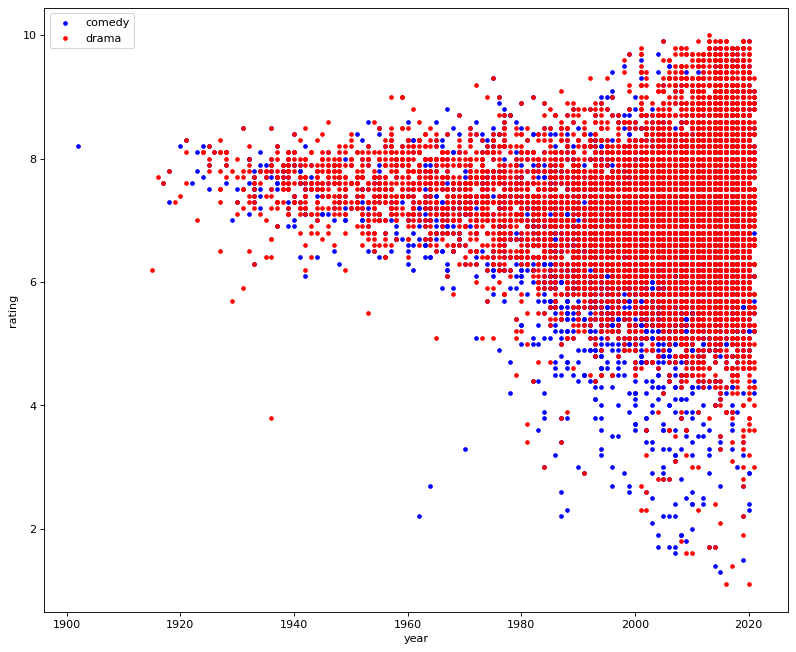

In [122]:
year_comedy = new_df[new_df['genre'] == 'Comedy']['year']
rating_comedy = new_df[new_df['genre'] == 'Comedy']['rating']
year_drama = new_df[new_df['genre'] == 'Drama']['year']
rating_drama = new_df[new_df['genre'] == 'Drama']['rating']

plt.figure(figsize=(12,10), dpi=80)

plt.scatter(year_comedy, rating_comedy, color='blue', label='comedy', s=10)
plt.scatter(year_drama, rating_drama, color='red', label='drama', s=10)

plt.ylabel('rating')
plt.xlabel('year')
plt.legend(loc='best') 
plt.show()

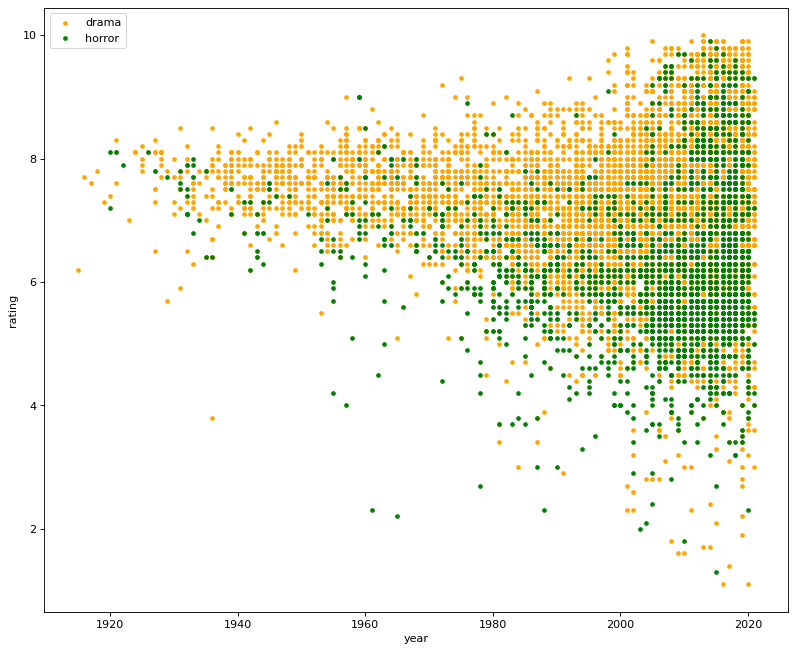

In [127]:
year_drama = new_df[new_df['genre'] == 'Drama']['year']
rating_drama = new_df[new_df['genre'] == 'Drama']['rating']
year_horror = new_df[new_df['genre'] == 'Horror']['year']
rating_horror = new_df[new_df['genre'] == 'Horror']['rating']

plt.figure(figsize=(12,10), dpi=80)

plt.scatter(year_drama, rating_drama, color='orange', label='drama', s=10)
plt.scatter(year_horror, rating_horror, color='green', label='horror', s=10)

plt.ylabel('rating')
plt.xlabel('year')
plt.legend(loc='best') 
plt.show()

# Train classification model

In [145]:
train_df = new_df.drop(columns=['title', 'genre'])
train_df['is_adult'] = df['is_adult']
train_df['runtime'] = df['runtime_minutes']
train_df['votes'] = df['votes']
train_df['type'] = df['type']

train_df

,year,rating,is_adult,runtime,votes,type
0,1895.0,6.9,0,1.0,1702,short
1,1895.0,6.9,0,5.0,210,short
2,1896.0,7.4,0,4.0,1458,short
3,1896.0,7.4,0,12.0,123,short
4,1902.0,8.2,0,1.0,2259,short
...,...,...,...,...,...,...
44311,2019.0,8.4,0,91.0,520,movie
44312,2019.0,8.4,0,2.0,413,short
44313,2019.0,10.0,0,87.0,508,movie
44314,2019.0,10.0,0,101.0,284,movie


One Hot Encoding to turn categorical values into binary:

In [146]:
train_df = pd.get_dummies(train_df)

In [147]:
train_df['genre'] = new_df['genre']

In [148]:
train_df

,year,rating,is_adult,runtime,votes,type_movie,type_short,type_tvEpisode,type_tvMiniSeries,type_tvMovie,type_tvSeries,type_tvShort,type_tvSpecial,type_video,genre
0,1895.0,6.9,0,1.0,1702,0,1,0,0,0,0,0,0,0,Documentary
1,1895.0,6.9,0,5.0,210,0,1,0,0,0,0,0,0,0,Short
2,1896.0,7.4,0,4.0,1458,0,1,0,0,0,0,0,0,0,Documentary
3,1896.0,7.4,0,12.0,123,0,1,0,0,0,0,0,0,0,Short
4,1902.0,8.2,0,1.0,2259,0,1,0,0,0,0,0,0,0,Adventure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44311,2019.0,8.4,0,91.0,520,1,0,0,0,0,0,0,0,0,Action
44312,2019.0,8.4,0,2.0,413,0,1,0,0,0,0,0,0,0,Thriller
44313,2019.0,10.0,0,87.0,508,1,0,0,0,0,0,0,0,0,Action
44314,2019.0,10.0,0,101.0,284,1,0,0,0,0,0,0,0,0,Adventure


In [149]:
# Use numpy to convert to arrays
import numpy as np

# Labels are the values we want to predict
labels = np.array(train_df['genre'])

# Remove the labels from the features
# axis 1 refers to the columns
features= train_df.drop('genre', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [150]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25,
                                                                           random_state = 42)

Getting rid of empty and infinite values in the arrays using numpy:

In [152]:
train_features = np.nan_to_num(train_features)
test_features = np.nan_to_num(test_features)
train_labels = np.nan_to_num(train_labels)
test_labels = np.nan_to_num(test_labels)

Training the model:

In [153]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(train_features, train_labels)

y_pred=clf.predict(test_features)

In [154]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_labels, y_pred))

Accuracy: 0.15046484339741853


Showing reports to get a better look at the metrics:

In [203]:
print(metrics.classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

      Action       0.11      0.10      0.11      1068
   Adventure       0.09      0.07      0.08       781
   Animation       0.05      0.02      0.03       329
   Biography       0.06      0.03      0.04       247
      Comedy       0.14      0.17      0.15      1427
       Crime       0.09      0.07      0.08       939
 Documentary       0.00      0.00      0.00        78
       Drama       0.24      0.44      0.31      2413
      Family       0.01      0.00      0.00       273
     Fantasy       0.05      0.02      0.03       346
   Film-Noir       0.07      0.04      0.05        24
   Game-Show       0.00      0.00      0.00         6
     History       0.00      0.00      0.00       181
      Horror       0.08      0.06      0.07       466
       Music       0.00      0.00      0.00       106
     Musical       0.00      0.00      0.00        55
     Mystery       0.05      0.02      0.03       462
        News       0.00    

Results: these features are not enough to train a decent classification model. 

# Movie plots

In [ ]:
new_df = pd.DataFrame()
counter = 0

for i in tqdm(small_df['genres']):
    genres = i.split(',')
    if len(genres) > 1:
        for j in genres:
            a = pd.DataFrame({'title_id': small_df.iloc[counter]['title_id'], 
                                'genre': j, 
                                'year': small_df.iloc[counter]['premiered'],
                                'rating': small_df.iloc[counter]['rating']})
            new_df = new_df.append(a, ignore_index=True)
    counter += 1

In [169]:
import re

Using imdp API to extract plots for movies

In [170]:
!pip install imdbpy

     |████████████████████████████████| 307kB 29.0MB/s 


In [175]:
tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [171]:
from imdb import IMDb

ia = IMDb()

Defining the fuction that uses IMDB API to get plots of the movies:

In [183]:
def get_plot(id):
  imdb_id = re.findall('tt0+(.*)', id)[0]
  movie = ia.get_movie(imdb_id)
  plot = movie['plot'][0]
  out = re.findall('(.+)::', plot)
  if out:
    return out[0]
  else:
    return None

Splitting dataframe by genre

In [185]:
horror_df = new_df[new_df['genre'] == 'Horror']
horror_df = horror_df[:500]
comedy_df = new_df[new_df['genre'] == 'Comedy']
comedy_df = comedy_df[:500]
drama_df = new_df[new_df['genre'] == 'Drama']
drama_df = drama_df[:500]
horror_df.shape, comedy_df.shape, drama_df.shape

((500, 4), (500, 4), (500, 4))

In [190]:
horror_df['plot'] = horror_df['title_id'].apply(get_plot)
comedy_df['plot'] = comedy_df['title_id'].apply(get_plot)
drama_df['plot'] = drama_df['title_id'].apply(get_plot)

In [191]:
horror_df = horror_df.dropna()
comedy_df = comedy_df.dropna()
drama_df = drama_df.dropna()

Preparing plots for wordcloud

In [192]:
!pip install pymorphy2

     |████████████████████████████████| 61kB 6.2MB/s 
     |████████████████████████████████| 8.2MB 36.6MB/s 


In [193]:
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

In [195]:
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stops = set(stopwords.words('russian') + ['это', 'весь', 'который', 'мочь', 'свой'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [196]:
def lemmatize(text):
    stopwords_ = stopwords.words('russian')

    text = re.sub('\d+', '', text)
    new_words = []
    new_text = re.findall('\w+', text)
    
    for w in range(len(new_text)):
        new_words.append(morph.parse(new_text[w])[0].normal_form)
    n_text = " ".join(new_words)
    words = n_text.split(' ')
    needed_w = []
    
    for w in words:
        if w not in stopwords_:
            needed_w.append(w)
    
    return ' '.join(needed_w)

In [197]:
horror_df['lemmatized_plot'] = horror_df['plot'].apply(lemmatize)
comedy_df['lemmatized_plot'] = comedy_df['plot'].apply(lemmatize)
drama_df['lemmatized_plot'] = drama_df['plot'].apply(lemmatize)

In [198]:
horror_texts = list(horror_df['lemmatized_plot'])
comedy_texts = list(comedy_df['lemmatized_plot'])
drama_texts = list(drama_df['lemmatized_plot'])

In [199]:
hc = ' '.join(horror_texts)
cc = ' '.join(comedy_texts)
dc = ' '.join(drama_texts)

Creating wordclouds:

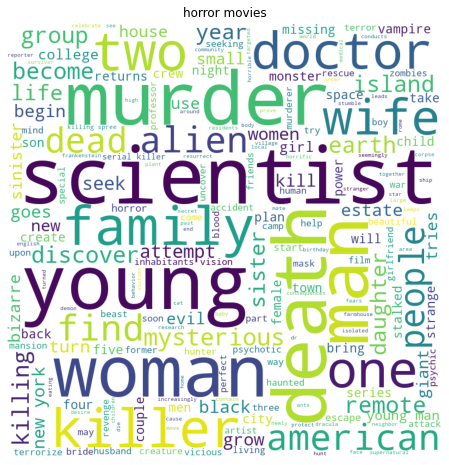

In [200]:
wordcloud = WordCloud(
    background_color ='white',
    width = 800,
    height = 800, 
).generate(hc)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud)
plt.axis("off") 
plt.title('horror movies')
plt.show()

Results are quite expected: "killing", "mysterious", "murder", "monster" and other words are very telling of the genre. 

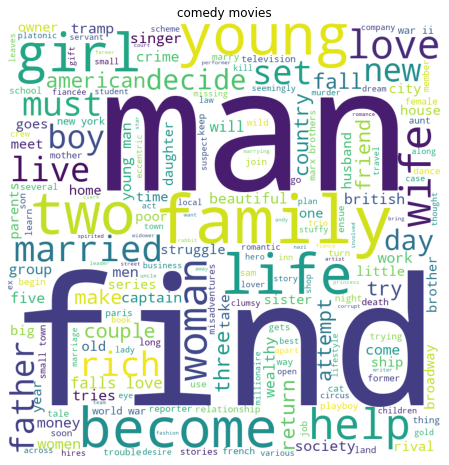

In [201]:
wordcloud = WordCloud(
    background_color ='white',
    width = 800,
    height = 800, 
).generate(cc)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud)
plt.axis("off") 
plt.title('comedy movies')
plt.show()

Again, results are not unexpected. Notice the difference between this wordcloud and the previous one. 

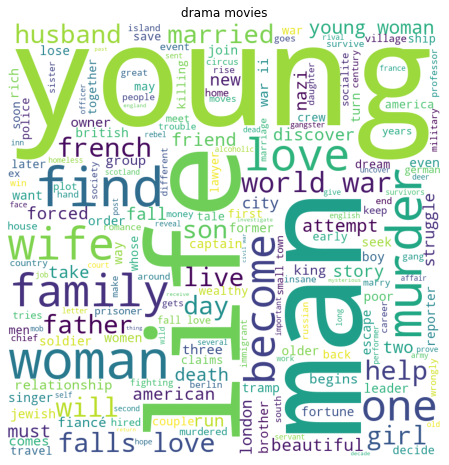

In [202]:
wordcloud = WordCloud(
    background_color ='white',
    width = 800,
    height = 800, 
).generate(dc)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud)
plt.axis("off") 
plt.title('drama movies')
plt.show()

"Love", "war", "death" and other words are specific to the genre, so once again we got the results that we expected.

# Other results: adult vs. non-adult movie comparison, career paths of top directors etc.

Other results including information about directors can be found in a separate colab: https://colab.research.google.com/drive/1czFMSRK8__eKUbXpaf7KIrJDb7Qedx3n?usp=sharing